In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Define a function to extract a time series and pull out coherence over time at a specific point, after making corrections (subtract elev-depending ref value). Converts to cm also.

In [2]:
# j is interval, y is y-coord of pixel, x is x-coord of pixel
def time_series(j,y,x,avg_ref_vals,elev,slopes):
    
    # choose one: 'filt' or 'unfilt'
    key1 = 'unfilt'
    # choose one: 'avg_val' or 'ref_box' or 'ref_pix'
    key2 = 'ref_pix'
    
    #igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
    igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
    # cohDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
    cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
    #saveDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
    saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
    
    # this one is to pick out the dates 
    datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
    # load in dates, make sure they are in order
    dates = [os.path.basename(d) for d in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
    nd = len(dates); numIgrams = nd-1
    
    start_indices = [0,47,108,147,0,0,107]
    end_indices = [46,107,146,numIgrams,88,numIgrams,153]

    # larger cropped area with western mountains 
    dx = 4000
    dy = 1100

    # pick out indices from the interval (interval j)
    interval_length = end_indices[j]-start_indices[j]
    print(str(interval_length)+' dates in interval '+str(j)+'.')
    
    # set up temp arrays for the row I'm extracting each time 
    temp_phs = np.ndarray((interval_length,),dtype='float')
    temp_coh = np.ndarray((interval_length,),dtype='float')

    elev_min = min(elev.flatten())

    # load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
    for i in range(interval_length):
        #print(start_indices[j]+i)
        date1 = dates[start_indices[j]+i]
        date2 = dates[start_indices[j]+i+1]
        igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        # only reading in one row at a time 
        temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)     # (startx,starty,dx,dy)  
        # correct for topography 
        temp_phs[i] = temp_phs[i] - (elev[y,x]-elev_min)*slopes[i] # + intercepts[i])
        # correct based on avg ref values and topography correction
        temp_phs[i] = temp_phs[i] - avg_ref_vals[start_indices[j]+i]
        # load one line of coherence files
        cohFile = 'coh_'+date1+'-'+date2+'.r4'
        ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
        # only reading in one row at a time
        temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)
    # times of SLCs in interval j
    # dates is a list of strings, convert strings to datetime objects 
    slc_dates=[]
    for i in range(0,len(dates)):
        slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
    t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting

    # coherence at that pixel over the interval, use this to calc variance.
    coh_at_pixel = temp_coh                                     # all dates, just the one pixel 
    disps = np.copy(temp_phs)                                            # this is disp over igrams in interval, for the single pixel  
    # Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
    cum_disps = np.hstack((0,np.cumsum(disps)))
    # make a conversion factor from radians to cm. 
    wavelength = 5.5465763                                      # C-band, in cm 
    rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
    cum_disps = cum_disps*rad2cm

    return t_datetime, cum_disps, coh_at_pixel

In [3]:
# choose one: 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
# dx = 3000
# dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)  


In [4]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

Reference pixel mask loaded.


Load each igram, calculate the elevation vs. phase relationship (slope and intercept) for points with elevation over a threshold (capturing mostly just bedrock), save those values for each igram.

In [5]:
slopes = np.ndarray((numIgrams,),dtype='float')
intercepts = np.ndarray((numIgrams,),dtype='float')

elev_cutoff = 150

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'

# load the DEM
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
print('DEM loaded.')

for i in range(numIgrams):
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # add condition that elevations over 125 m (relationship applies best for bedrock/high elevations)
    phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
    els = elev.flatten()[(elev.flatten() > elev_cutoff)]
    m, b = np.polyfit(els,phs,1)
    slopes[i] = m
    intercepts[i] = b
    print('i: '+str(i)+'\tslope: '+str(m)+' rad/m, intercept: '+str(b)+' rad.')
print('done.')

DEM loaded.
i: 0	slope: 0.01241251172152888 rad/m, intercept: 0.5799043700293077 rad.
i: 1	slope: -0.001237643759311598 rad/m, intercept: 5.66822597921317 rad.
i: 2	slope: 0.0037987951394297535 rad/m, intercept: 4.2320930782462955 rad.
i: 3	slope: -6.393251166938018e-05 rad/m, intercept: 4.812916999222578 rad.
i: 4	slope: -0.027911991791034194 rad/m, intercept: 5.389925756862012 rad.
i: 5	slope: 0.005120650929677574 rad/m, intercept: -7.321966912220836 rad.
i: 6	slope: 0.004388923178270809 rad/m, intercept: 8.735166537019571 rad.
i: 7	slope: 0.02175054278290128 rad/m, intercept: -0.1763825835690034 rad.
i: 8	slope: -0.010299991506888309 rad/m, intercept: 4.518148218134091 rad.
i: 9	slope: -0.015881993257742068 rad/m, intercept: 1.1693563857777867 rad.
i: 10	slope: 0.019133614867265468 rad/m, intercept: 2.512691782324248 rad.
i: 11	slope: -0.001999100959418041 rad/m, intercept: 6.937166182054907 rad.
i: 12	slope: 0.005216626524430997 rad/m, intercept: 6.064106445492683 rad.
i: 13	slope:

Read in each unfilt, unwrapped igram and calculate the average phase value over all reference pixels and save it into array. 

In [6]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
avg_ref_vals = np.ndarray((numIgrams,),dtype='float')
# ignore the divide-by-zero error messages that pop up in each loop iteration.
np.seterr(divide='ignore', invalid='ignore')

elev_min = min(elev.flatten())

# igramsDir is where the cropped, unwrapped igrams are
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
for i in range(numIgrams): # numIgrams if doing all of them at once
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    
    # remove the topography effects
    temp_igram = temp_igram - (elev-elev_min)*slopes[i] # + intercepts[i]
    
    # Now mask the igram based on ref pixels and filter it.
    igram_masked = np.zeros((dy,dx))
    igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
    igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
    ab = igram_filt / ref_mask_filt
    avg_ref_vals[i] = np.nanmean(ab) 
    print('i: '+str(i)+'\tavg_ref_val: '+str('%.4f' % avg_ref_vals[i]))
print('Avg value of ref pixels calculated for all '+key1+' igrams.')

# save space/RAM and clean up these variables now. 
del igramFile, ds, temp_igram

i: 0	avg_ref_val: 0.8398
i: 1	avg_ref_val: 5.7130
i: 2	avg_ref_val: 3.7992
i: 3	avg_ref_val: 3.7529
i: 4	avg_ref_val: 6.4950
i: 5	avg_ref_val: -6.3085
i: 6	avg_ref_val: 9.9731
i: 7	avg_ref_val: -1.7975
i: 8	avg_ref_val: 5.3528
i: 9	avg_ref_val: 1.3449
i: 10	avg_ref_val: 1.7233
i: 11	avg_ref_val: 6.3033
i: 12	avg_ref_val: 5.9253
i: 13	avg_ref_val: 2.6652
i: 14	avg_ref_val: 5.7721
i: 15	avg_ref_val: 3.4966
i: 16	avg_ref_val: 6.1781
i: 17	avg_ref_val: 5.7451
i: 18	avg_ref_val: 0.8076
i: 19	avg_ref_val: 1.8332
i: 20	avg_ref_val: 1.5750
i: 21	avg_ref_val: 0.3616
i: 22	avg_ref_val: 7.2572
i: 23	avg_ref_val: 4.9753
i: 24	avg_ref_val: 0.6021
i: 25	avg_ref_val: 0.9514
i: 26	avg_ref_val: 6.6875
i: 27	avg_ref_val: 4.6644
i: 28	avg_ref_val: 4.5025
i: 29	avg_ref_val: 1.9652
i: 30	avg_ref_val: -0.2609
i: 31	avg_ref_val: 2.0633
i: 32	avg_ref_val: 4.7120
i: 33	avg_ref_val: 1.6432
i: 34	avg_ref_val: 4.1200
i: 35	avg_ref_val: 6.0280
i: 36	avg_ref_val: 10.6655
i: 37	avg_ref_val: -2.7586
i: 38	avg_ref_val

In [7]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(start_indices)

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]]+' - '+str(dates[end_indices[i]])))

interval 0: 20170510 - 20181125
interval 1: 20181207 - 20200412
interval 2: 20200418 - 20201208
interval 3: 20201214 - 20220108
interval 4: 20170510 - 20191220
interval 5: 20170510 - 20220108
interval 6: 20200412 - 20210119


In [8]:
# define third set of boxes. First ones weren't good enough.
from matplotlib.patches import Rectangle
box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]
box2x = [3500, 4000]; box2dx = box2x[1]-box2x[0] 
box2y = [200, 300];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [0, 100];   box3dy = box3y[1]-box3y[0]
box4x = [3500, 4000];  box4dx = box4x[1]-box4x[0]
box4y = [1000,1100];   box4dy = box4y[1]-box4y[0]

boxes = ['box1','box2','box3','box4']
numBoxes=len(boxes)
print(str(numBoxes)+' boxes.')

4 boxes.


In [9]:
# which interval? the whole time period, interval 5:
j = 5

Load velocity map for the interval chosen above.

In [10]:
# load in the velocity map to plot the points on it where I'm showing full time series. 

# read in disp rate file + rmse file
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 
f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None
print('interval '+str(j)+' disp rate map + errors loaded.')

interval 5 disp rate map + errors loaded.


Load in the masks for population 1 and population 2.

In [11]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/'
file1 = 'pop1_mask.r4'
#file1 = 'pop1_mask_version2.r4'
f1 = gdal.Open(loadDir+file1, gdal.GA_ReadOnly)
pop1_mask = f1.ReadAsArray()
f1 = None
file2 = 'pop2_mask.r4'
#file2 = 'pop2_mask_version2.r4'
f1 = gdal.Open(loadDir+file2, gdal.GA_ReadOnly)
pop2_mask = f1.ReadAsArray()
f1 = None
print('pop1 and pop2 masks loaded.')

pop1 and pop2 masks loaded.


In [12]:
pops = np.zeros((dy,dx))
pops[pop1_mask==1.0]=1.0
pops[pop2_mask==1.0]=2.0

In [13]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


pt		pop		disp rate (rad/yr)	(cm/yr)
1		1e+00		0.7029526		0.31027099871912983
2		2.0		0.50474083		0.2227837801964427


210 dates in interval 5.
210 dates in interval 5.


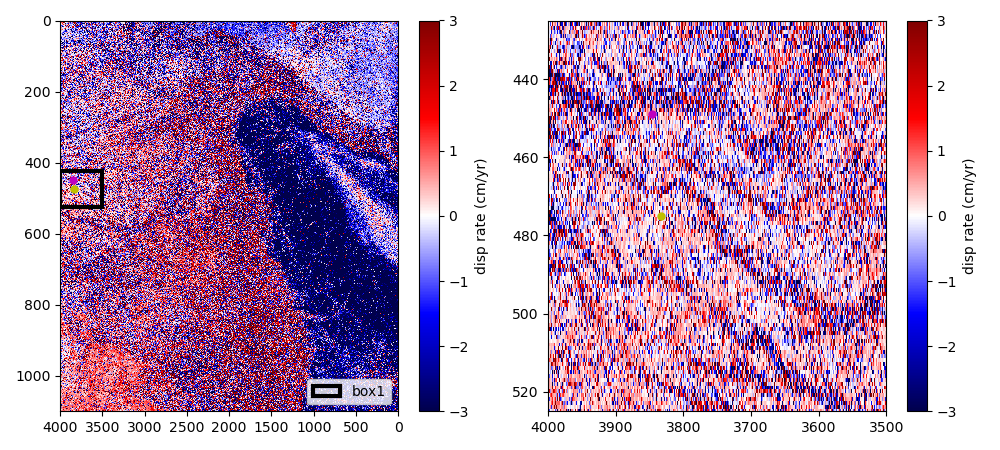

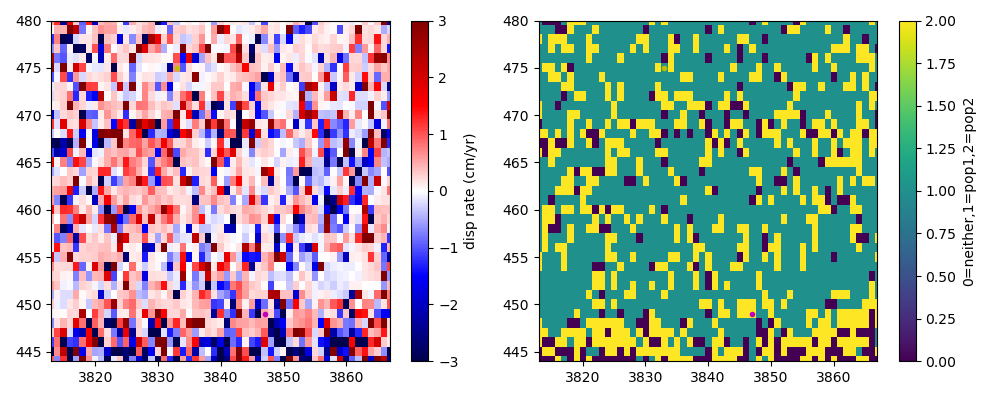

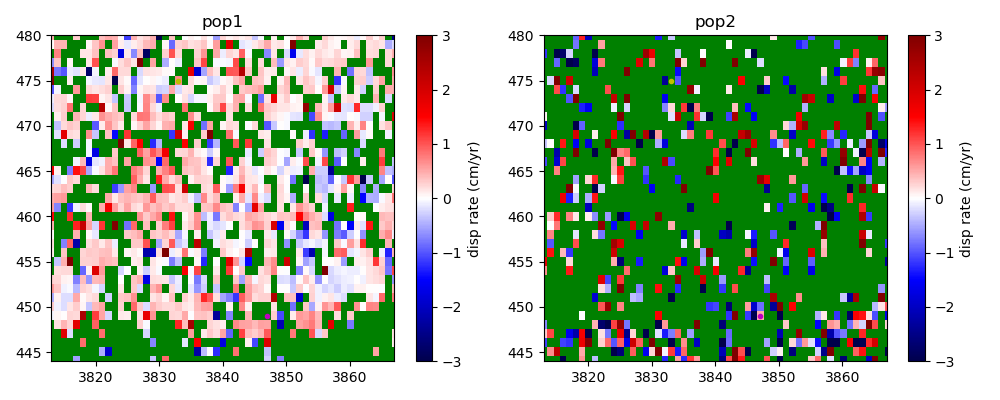

pop1
-0.32989785 in box1
0.16447248 in the area shown
pop2
-1.037228 in box2
-0.043382943 in the area shown


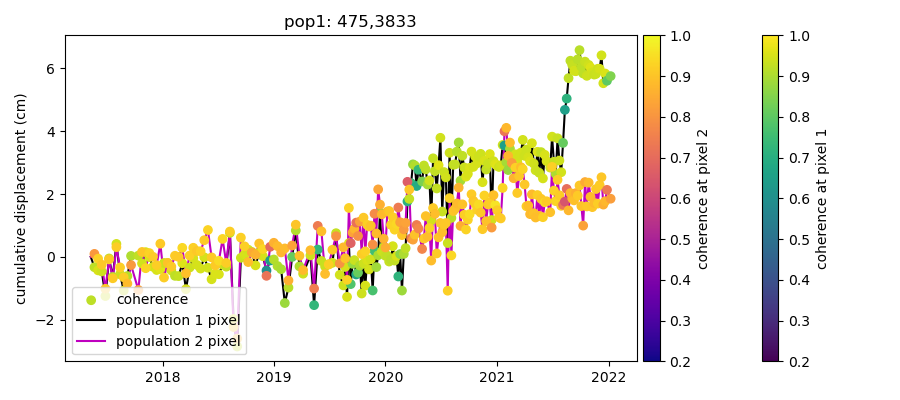

In [14]:
# choose an y,x coordinate, which pixel? 

# extreme example 
y2 = 445
x2 = 3824

y2 = 450-1
x2 = 3846+1


# this one is ok for extreme example too 
# y2 = 443
# x2 = 3826
y1 = 448
x1 = 3835

# testing 
y1 = 475
x1 = 3833

# more median-behavior example 
# y1 = 450
# x1 = 3848

# y2 = 452
# x2 = 3848

print('pt\t\tpop\t\tdisp rate (rad/yr)\t(cm/yr)')
print('1\t\t'+str(pops[y1,x1])+'\t\t'+str(disp_rates[y1,x1])+'\t\t'+str(disp_rates[y1,x1]*rad2cm))
print('2\t\t'+str(pops[y2,x2])+'\t\t'+str(disp_rates[y2,x2])+'\t\t'+str(disp_rates[y2,x2]*rad2cm))

t_datetime_pt1, cum_disps_pt1, coh_at_pixel_pt1 = time_series(j,y1,x1,avg_ref_vals,elev,slopes)
t_datetime_pt2, cum_disps_pt2, coh_at_pixel_pt2 = time_series(j,y2,x2,avg_ref_vals,elev,slopes)

#velocity map with pixel(s) as points. 
plt.figure(figsize=(10,4.5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(disp_rates,cmap='seismic',aspect='auto',vmin=-3,vmax=3,interpolation='none')
plt.plot(x1,y1,'y.',ms=10)
plt.plot(x2,y2,'m.',ms=10)
plt.colorbar(label='disp rate (cm/yr)')
#plt.yticks([]); plt.xticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
# plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
# plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
# plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.subplot(1,2,2)
plt.imshow(disp_rates,cmap='seismic',aspect='auto',vmin=-3,vmax=3,interpolation='none')
plt.plot(x1,y1,'y.',ms=10)
plt.plot(x2,y2,'m.',ms=10)
plt.colorbar(label='disp rate (cm/yr)')
plt.xlim([box1x[1],box1x[0]]); plt.ylim([box1y[1],box1y[0]])
plt.show()


plt.figure(figsize=(10,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(disp_rates,cmap='seismic',aspect='auto',vmin=-3,vmax=3,interpolation='none')
plt.plot(x1,y1,'y.')
plt.plot(x2,y2,'m.')
plt.xlim([min([x1,x2])-20,max([x1,x2])+20]);plt.ylim([min([y1,y2])-5,max([y1,y2])+5])
plt.colorbar(label='disp rate (cm/yr)')
plt.subplot(1,2,2)
plt.imshow(pops,cmap='viridis',aspect='auto')
plt.plot(x1,y1,'y.')
plt.plot(x2,y2,'m.')
plt.xlim([min([x1,x2])-20,max([x1,x2])+20]);plt.ylim([min([y1,y2])-5,max([y1,y2])+5])
plt.colorbar(label='0=neither,1=pop1,2=pop2')
plt.show()

# only show pop1 and pop2, separately 
pop1 = np.copy(disp_rates)
pop1[pops!=1] = np.nan
pop2 = np.copy(disp_rates)
pop2[pops!=2] = np.nan

plt.figure(figsize=(10,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pop1,cmap=seismic2,aspect='auto',vmin=-3,vmax=3)
plt.plot(x1,y1,'y.')
plt.plot(x2,y2,'m.')
plt.colorbar(label='disp rate (cm/yr)')
plt.xlim([min([x1,x2])-20,max([x1,x2])+20]);plt.ylim([min([y1,y2])-5,max([y1,y2])+5])
plt.title('pop1')
plt.subplot(1,2,2)
plt.imshow(pop2,cmap=seismic2,aspect='auto',vmin=-3,vmax=3)
plt.plot(x1,y1,'y.')
plt.plot(x2,y2,'m.')
plt.colorbar(label='disp rate (cm/yr)')
plt.xlim([min([x1,x2])-20,max([x1,x2])+20]);plt.ylim([min([y1,y2])-5,max([y1,y2])+5])
plt.title('pop2')
plt.show()

print('pop1')
print(str(np.nanmedian(pop1))+' in box1')
print(str(np.nanmedian(pop1[min([y1,y2])-5:max([y1,y2])+5,min([x1,x2])-20:max([x1,x2])+20]))+' in the area shown')
print('pop2')
print(str(np.nanmedian(pop2))+' in box2')
print(str(np.nanmedian(pop2[min([y1,y2])-5:max([y1,y2])+5,min([x1,x2])-20:max([x1,x2])+20]))+' in the area shown')

#print(np.nanmedian(disp_rates))
# time series colored by coherence for both points
plt.figure(figsize=(9,4),tight_layout=True)
plt.scatter(t_datetime_pt1[1::],cum_disps_pt1[1::],c=coh_at_pixel_pt1,cmap='viridis',vmin=0.2,vmax=1,label='coherence',zorder=2.5)
plt.plot(t_datetime_pt1,cum_disps_pt1,'k-',label='population 1 pixel')
plt.colorbar(label='coherence at pixel 1',pad=0.02)
plt.scatter(t_datetime_pt2[1::],cum_disps_pt2[1::],c=coh_at_pixel_pt2,cmap='plasma',vmin=0.2,vmax=1,zorder=2.5)
plt.plot(t_datetime_pt2,cum_disps_pt2,'m-',label='population 2 pixel')
plt.ylabel('cumulative displacement (cm)')
plt.legend(loc='lower left')
plt.colorbar(label='coherence at pixel 2',pad=0.01)
plt.title('pop1: '+str(y1)+','+str(x1))
plt.show()

210 dates in interval 5.


210 dates in interval 5.
time series for set 0 calculated.


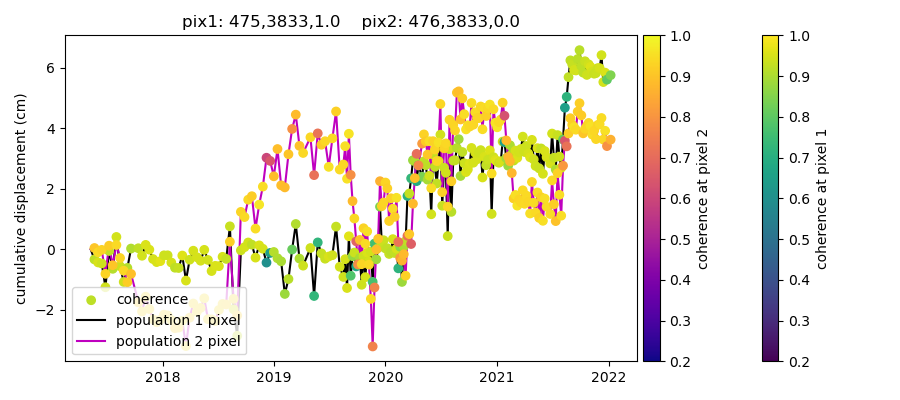

210 dates in interval 5.
210 dates in interval 5.
time series for set 1 calculated.


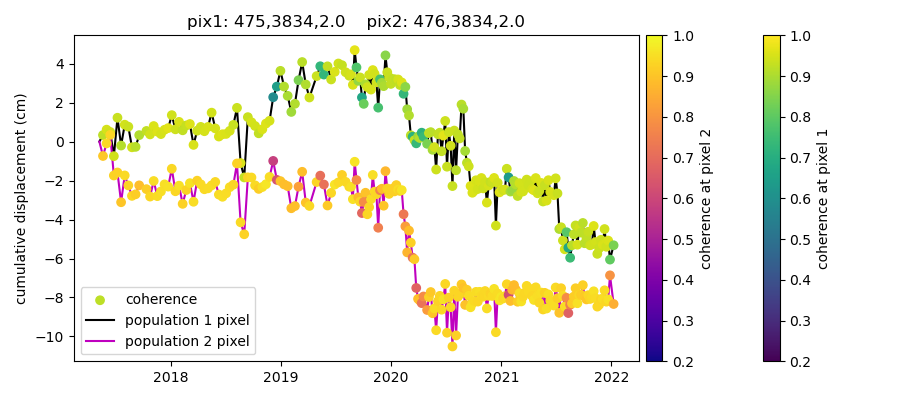

210 dates in interval 5.
210 dates in interval 5.
time series for set 2 calculated.


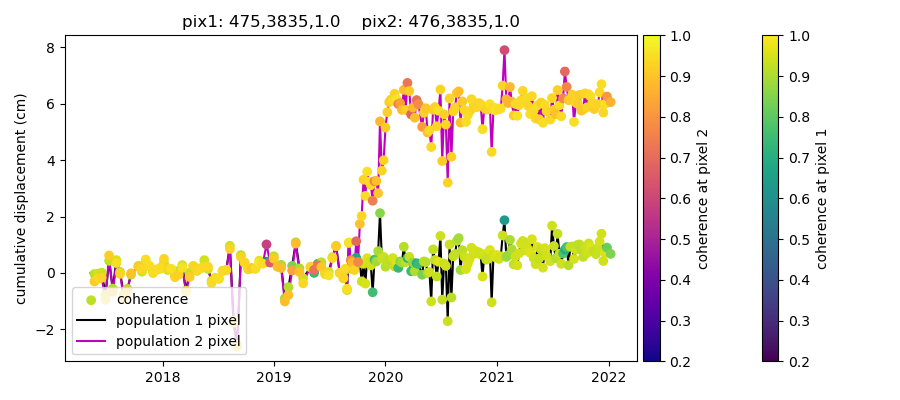

210 dates in interval 5.
210 dates in interval 5.
time series for set 3 calculated.


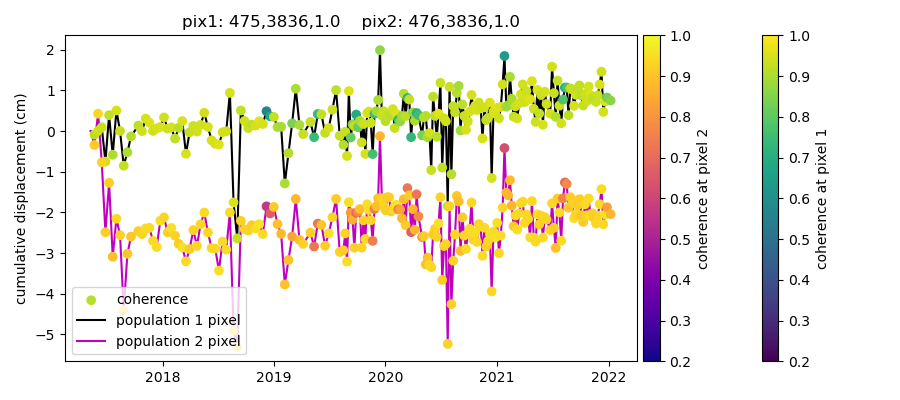

210 dates in interval 5.
210 dates in interval 5.
time series for set 4 calculated.


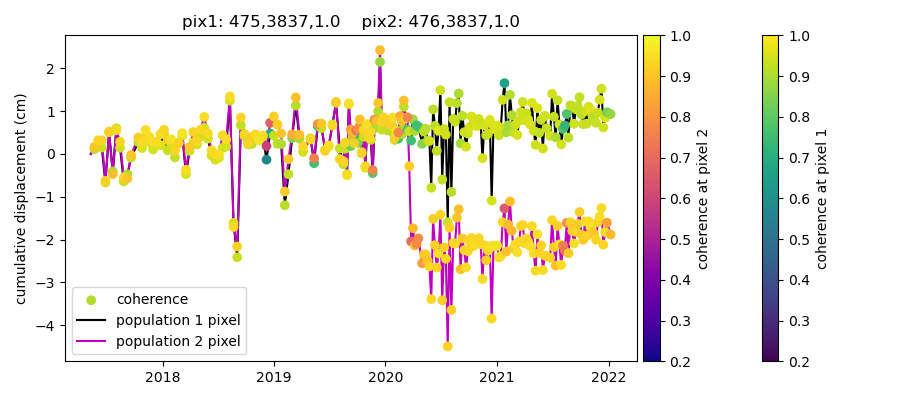

210 dates in interval 5.
210 dates in interval 5.
time series for set 5 calculated.


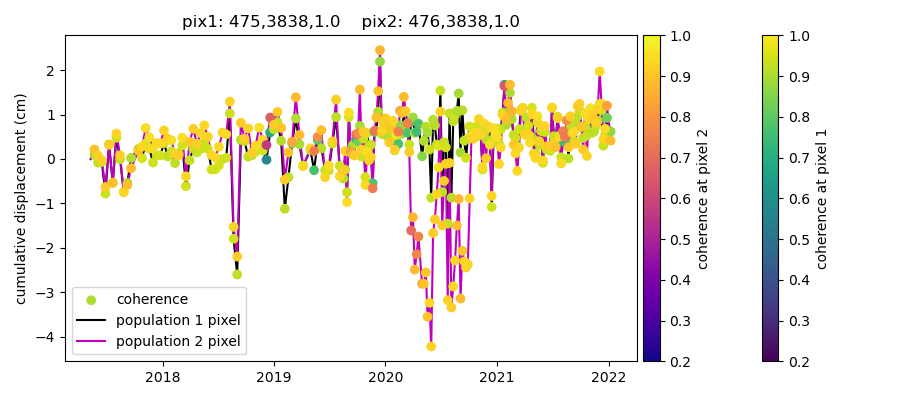

210 dates in interval 5.
210 dates in interval 5.
time series for set 6 calculated.


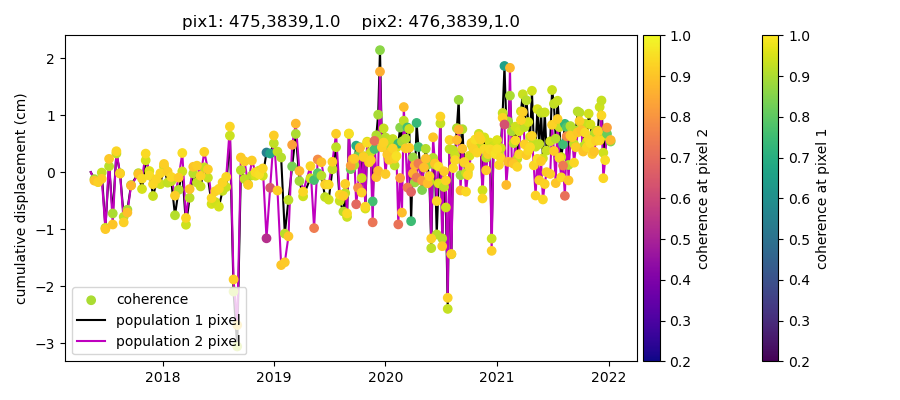

210 dates in interval 5.
210 dates in interval 5.
time series for set 7 calculated.


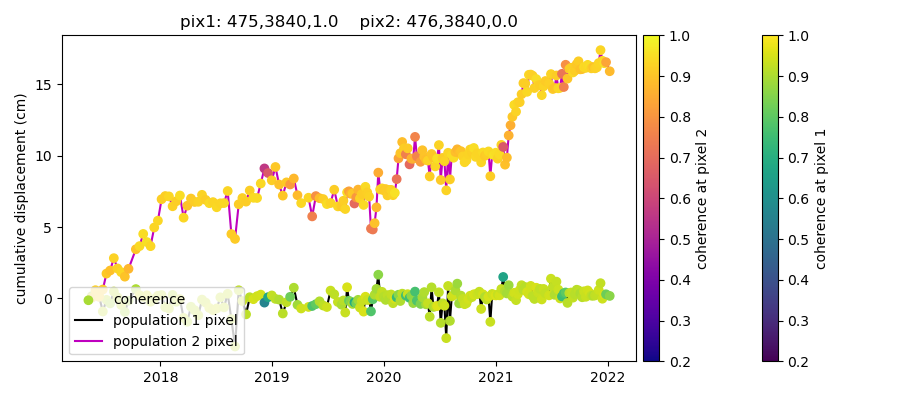

210 dates in interval 5.
210 dates in interval 5.
time series for set 8 calculated.


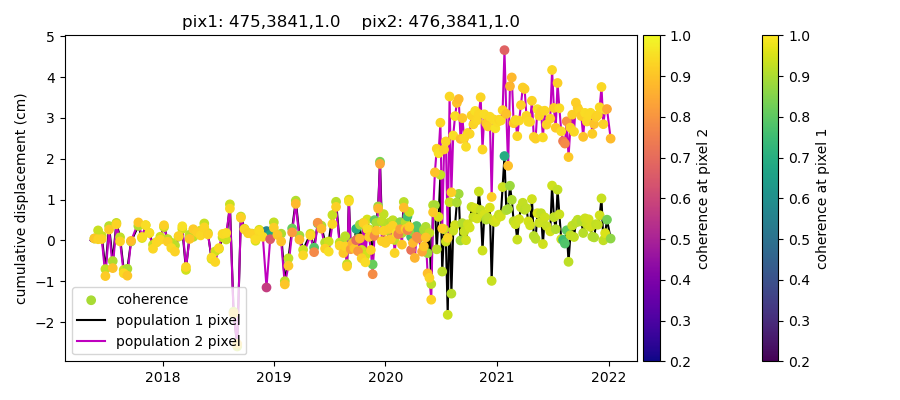

210 dates in interval 5.
210 dates in interval 5.
time series for set 9 calculated.


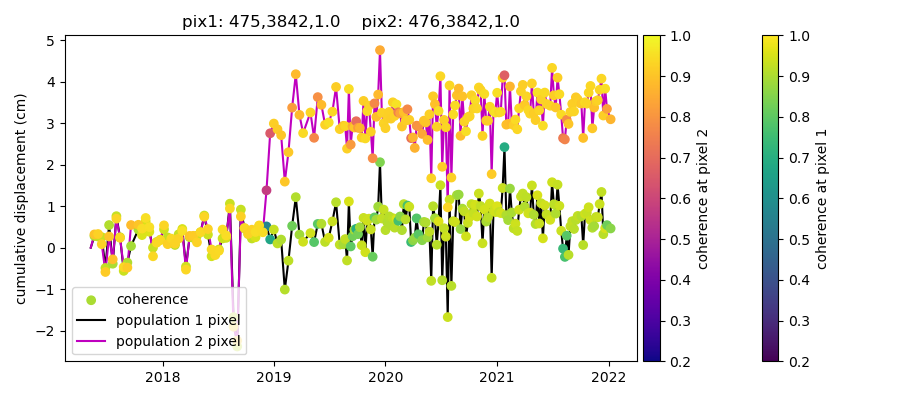

In [15]:
# loop through a bunch of sets of points and plot them. 
for i in range(10):
    y1_temp = y1
    y2_temp = y1+1
    x1_temp = x1+i
    x2_temp = x1+i
    t_datetime_pt1_temp, cum_disps_pt1, coh_at_pixel_pt1 = time_series(j,y1_temp,x1_temp,avg_ref_vals,elev,slopes)
    t_datetime_pt2_temp, cum_disps_pt2, coh_at_pixel_pt2 = time_series(j,y2_temp,x2_temp,avg_ref_vals,elev,slopes)
    print('time series for set '+str(i)+' calculated.')

    # time series colored by coherence for both points
    plt.figure(figsize=(9,4),tight_layout=True)
    plt.scatter(t_datetime_pt1_temp[1::],cum_disps_pt1[1::],c=coh_at_pixel_pt1,cmap='viridis',vmin=0.2,vmax=1,label='coherence',zorder=2.5)
    plt.plot(t_datetime_pt1_temp,cum_disps_pt1,'k-',label='population 1 pixel')
    plt.colorbar(label='coherence at pixel 1',pad=0.02)
    plt.scatter(t_datetime_pt2_temp[1::],cum_disps_pt2[1::],c=coh_at_pixel_pt2,cmap='plasma',vmin=0.2,vmax=1,zorder=2.5)
    plt.plot(t_datetime_pt2_temp,cum_disps_pt2,'m-',label='population 2 pixel')
    plt.ylabel('cumulative displacement (cm)')
    plt.legend(loc='lower left')
    plt.colorbar(label='coherence at pixel 2',pad=0.01)
    plt.title('pix1: '+str(y1_temp)+','+str(x1_temp)+','+str(pops[y1_temp,x1_temp])+'    pix2: '+str(y2_temp)+','+str(x2_temp)+','+str(pops[y2_temp,x2_temp]))
    plt.show()

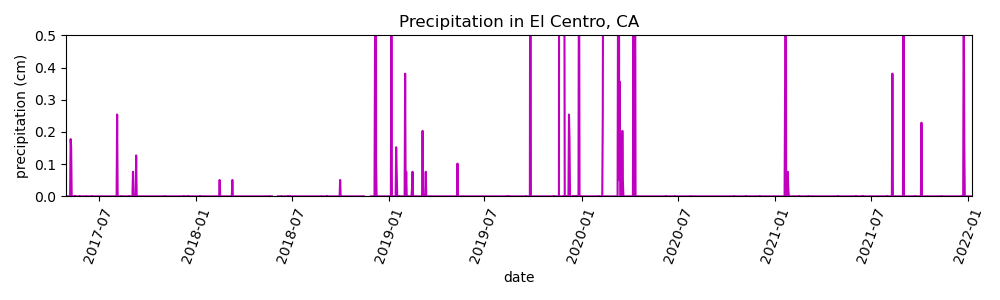

i 	date 		       precip > 0.0cm
584	2018-12-06 00:00:00    0.48260000000000003 cm
585	2018-12-07 00:00:00    4.572 cm
615	2019-01-06 00:00:00    0.5334 cm
641	2019-02-01 00:00:00    0.381 cm
878	2019-09-26 00:00:00    1.4478 cm
933	2019-11-20 00:00:00    2.286 cm
934	2019-11-21 00:00:00    1.016 cm
942	2019-11-29 00:00:00    1.016 cm
970	2019-12-27 00:00:00    0.9398 cm
1016	2020-02-11 00:00:00    1.1684 cm
1044	2020-03-10 00:00:00    0.7365999999999999 cm
1045	2020-03-11 00:00:00    2.4892 cm
1047	2020-03-13 00:00:00    0.3556 cm
1073	2020-04-08 00:00:00    0.6096 cm
1076	2020-04-11 00:00:00    0.9906 cm
1360	2021-01-20 00:00:00    0.3556 cm
1361	2021-01-21 00:00:00    1.7779999999999998 cm
1563	2021-08-11 00:00:00    0.381 cm
1584	2021-09-01 00:00:00    0.7112 cm
1698	2021-12-24 00:00:00    0.7112 cm


In [16]:
# Read in raw precipitation data and plot it 
file = '/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip.txt'
precip_all = np.loadtxt(file, delimiter=',', skiprows=3, dtype=str)
precipDates = precip_all[:,0]
precip_all = precip_all[:,1]
precip_all = precip_all.astype(float)
# convert to cm from inches 
precip_all = precip_all*2.54
# make the dates from precip.txt into datetime objects
my_dates=[]
for i in range(0,len(precipDates)):
    my_dates.append(datetime.strptime(str(precipDates[i]).replace('\n',''), '%Y-%m-%d'))

fig=plt.figure(figsize=(10,3), tight_layout=True)
#plt.xticks(np.arange(0, np.size(precipDates)+1, 182))
plt.xticks(rotation = 70)
#plt.plot(precipDates, precip,'-m')
plt.plot(my_dates, precip_all,'-m')
plt.xlabel('date')
plt.ylabel('precipitation (cm)')
plt.xlim([np.min(my_dates), np.max(my_dates)])
#plt.xlim([0, np.size(precip)])
plt.ylim([0,0.5])
plt.title('Precipitation in El Centro, CA')
plt.show()

print('i \tdate \t\t       precip > 0.0cm')
rainy_dates = []
rainy_amts = []
for i in np.arange(len(precip_all)): 
    if precip_all[i] > 0.3:
        print(str(i)+'\t'+str(my_dates[i])+'    '+str(precip_all[i])+' cm')
        rainy_dates.append(my_dates[i])
        rainy_amts.append(precip_all[i])
rainy_amts2 = np.ndarray((np.shape(rainy_amts)),dtype='float')
for i in range(len(rainy_amts)):
    rainy_amts2[i] = float(rainy_amts[i])
# normalize to the largest rain event so all values are btw 0-1
rainy_amts2 = rainy_amts2/np.max(rainy_amts)
rainy_amts2 = 0.8*rainy_amts2+0.2


Make the time series look different. 

In [17]:
print(2*np.pi*rad2cm)

2.77328815


210 dates in interval 5.


210 dates in interval 5.


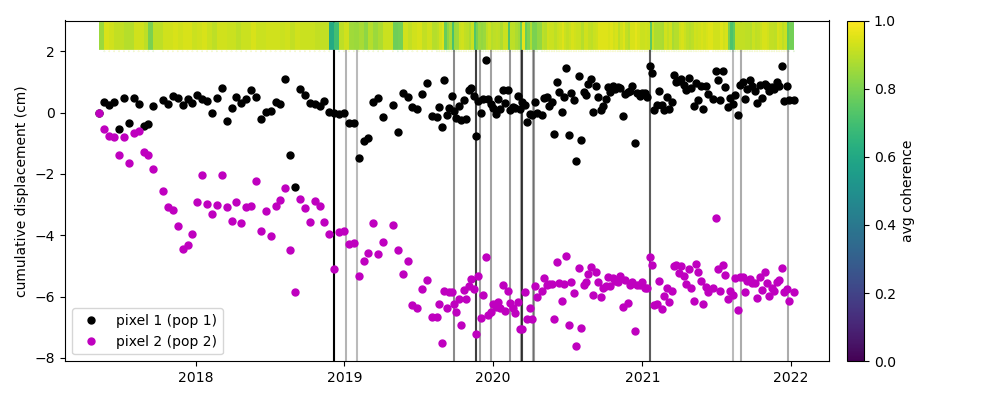

In [18]:
# two sets/pairs of pixels to go on Fringe poster, 9-23. 
x1=3839
y1=472

x2=3839
y2=471

t_datetime_pt1, cum_disps_pt1, coh_at_pixel_pt1 = time_series(j,y1,x1,avg_ref_vals,elev,slopes)
t_datetime_pt2, cum_disps_pt2, coh_at_pixel_pt2 = time_series(j,y2,x2,avg_ref_vals,elev,slopes)

# time series colored by coherence for both points
coh = (coh_at_pixel_pt1+coh_at_pixel_pt2)/2

from matplotlib import cm
coh_cmap = cm.get_cmap('viridis', 100)
#print(coh_cmap(0.5))

plt.figure(figsize=(10,4),tight_layout=True)

plt.scatter(t_datetime_pt1[1::],np.ones((nd-1))*2,c=coh_at_pixel_pt1,cmap='viridis',vmin=0,vmax=1,s=0.01)

plt.plot(t_datetime_pt1,cum_disps_pt1,'k.',markersize=10,label='pixel 1 (pop 1)')
plt.plot(t_datetime_pt2,cum_disps_pt2,'m.',markersize=10,label='pixel 2 (pop 2)')
plt.ylabel('cumulative displacement (cm)')
plt.legend(loc='lower left')
#plt.xlim([t_datetime_pt1[0],t_datetime_pt1[-1]])

y = 2.5
for i in range(nd-1):
    plt.hlines(y,t_datetime_pt1[i],t_datetime_pt1[i+1],color=coh_cmap(coh[i]),linewidth=20)
plt.colorbar(label='avg coherence',pad=0.02)

# ALL rainy days (not just day of/prior to an SLC date)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rainy_dates,Ymin,Ymax,'k',zorder=1,alpha=rainy_amts2)
plt.ylim([Ymin,Ymax])
plt.locator_params(axis="y", integer=True, tight=True)

#plt.title('x1: '+str(x1)+', y1: '+str(y1)+', x2: '+str(x2)+', y2: '+str(y2))
plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/time_series_set1.png',transparent=True)
plt.show()

210 dates in interval 5.


210 dates in interval 5.


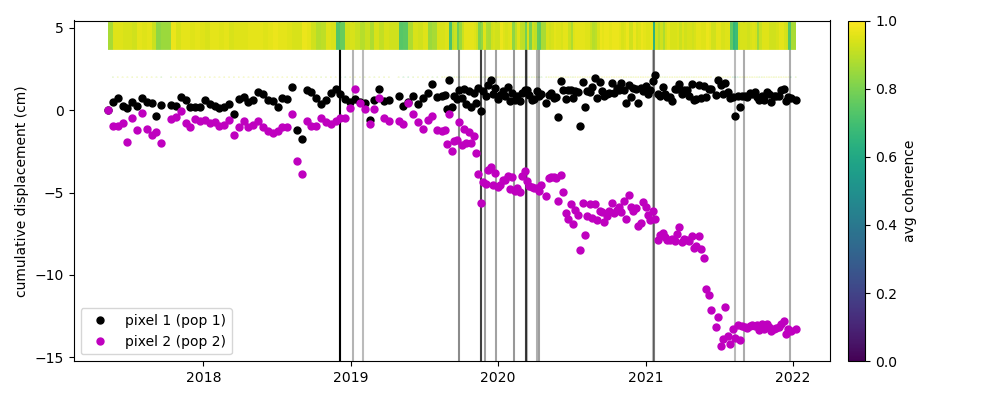

In [19]:
# two sets/pairs of pixels to go on Fringe poster, 9-23. 
x1=3838
y1=451

x2=3838
y2=452

t_datetime_pt1, cum_disps_pt1, coh_at_pixel_pt1 = time_series(j,y1,x1,avg_ref_vals,elev,slopes)
t_datetime_pt2, cum_disps_pt2, coh_at_pixel_pt2 = time_series(j,y2,x2,avg_ref_vals,elev,slopes)

# time series colored by coherence for both points
coh = (coh_at_pixel_pt1+coh_at_pixel_pt2)/2

from matplotlib import cm
coh_cmap = cm.get_cmap('viridis', 100)
#print(coh_cmap(0.5))

plt.figure(figsize=(10,4),tight_layout=True)

plt.scatter(t_datetime_pt1[1::],np.ones((nd-1))*2,c=coh_at_pixel_pt1,cmap='viridis',vmin=0,vmax=1,s=0.01)

plt.plot(t_datetime_pt1,cum_disps_pt1,'k.',markersize=10,label='pixel 1 (pop 1)')
plt.plot(t_datetime_pt2,cum_disps_pt2,'m.',markersize=10,label='pixel 2 (pop 2)')
plt.ylabel('cumulative displacement (cm)')
plt.legend(loc='lower left')
#plt.xlim([t_datetime_pt1[0],t_datetime_pt1[-1]])

y = 4.5
for i in range(nd-1):
    plt.hlines(y,t_datetime_pt1[i],t_datetime_pt1[i+1],color=coh_cmap(coh[i]),linewidth=20)
plt.colorbar(label='avg coherence',pad=0.02)

# ALL rainy days (not just day of/prior to an SLC date)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rainy_dates,Ymin,Ymax,'k',zorder=1,alpha=rainy_amts2)
plt.ylim([Ymin,Ymax])
plt.locator_params(axis="y", integer=True,tight=True)

#plt.title('x1: '+str(x1)+', y1: '+str(y1)+', x2: '+str(x2)+', y2: '+str(y2))
plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/time_series_set2.png',transparent=True)
plt.show()

In [20]:
print(np.shape(t_datetime_pt1))

(211,)


Now plot 10ish time series of each population in a small area. 

In [21]:
# center the small area at (448,3835) or (yCenter,xCenter)

yCenter = 450
xCenter = 3843

# yCenter = 683
# xCenter = 2560

# yCenter = 448
# xCenter = 3835

wid = 5

pop1_count = 0
pop2_count = 0

for y in range(yCenter,yCenter+wid,1):
    for x in range(xCenter,xCenter+wid,1):
        if pops[y,x] == 1:
            pop1_count += 1
        elif pops[y,x] == 2: 
            pop2_count += 1
print('pop1: '+str(pop1_count)+'\npop2: '+str(pop2_count))

TS_pop1 = np.zeros((pop1_count,numIgrams))
TS_pop2 = np.zeros((pop2_count,numIgrams))

pop1_input_spot = 0
pop2_input_spot = 0

coh_avg = np.zeros((numIgrams))

for y in range(yCenter,yCenter+wid,1):
    for x in range(xCenter,xCenter+wid,1):
        # now see if it goes with pop1 or pop2, only calculate time series if one of the two.
        if pops[y,x] == 1:
            # calculate time series 
            t_datetime_temp, cum_disps_temp, coh_at_pixel_temp = time_series(j,y,x,avg_ref_vals,elev,slopes)
            # now put the cum disps into the TS array 
            TS_pop1[pop1_input_spot] = cum_disps_temp[1::]
            pop1_input_spot += 1
            coh_avg += coh_at_pixel_temp
        elif pops[y,x] == 2: 
            t_datetime_temp, cum_disps_temp, coh_at_pixel_temp = time_series(j,y,x,avg_ref_vals,elev,slopes)
            TS_pop2[pop2_input_spot] = cum_disps_temp[1::]
            pop2_input_spot += 1
            coh_avg += coh_at_pixel_temp
coh_avg = coh_avg/(pop1_count+pop2_count)

pop1: 19
pop2: 6
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.
210 dates in interval 5.


Calculate 1sigma above and below median (or 84th and 16th percentiles) for each population of the time series.

In [22]:
above_percentile = 84
below_percentile = 16

pop1_above = np.percentile(TS_pop1,above_percentile,axis=0)
pop1_below = np.percentile(TS_pop1,below_percentile,axis=0)
pop1_median = np.median(TS_pop1,axis=0)
pop2_above = np.percentile(TS_pop2,above_percentile,axis=0)
pop2_below = np.percentile(TS_pop2,below_percentile,axis=0)
pop2_median = np.median(TS_pop2,axis=0)

In [23]:
print(np.shape(pop1_above))
print(np.shape(pop2_above))
print(np.shape(pop1_below))
print(np.shape(pop2_below))
print(np.shape(pop1_median))
print(np.shape(pop2_median))
print(np.shape(t_datetime_pt1[1::]))

(210,)
(210,)
(210,)
(210,)
(210,)
(210,)
(210,)


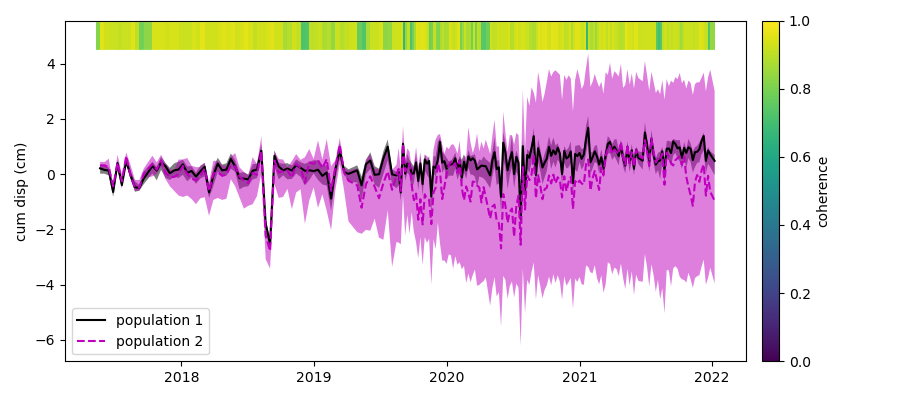

In [24]:
plt.figure(figsize=(9,4),tight_layout=True)
plt.scatter(t_datetime_pt1[1::],np.ones((nd-1))*5,c=coh_at_pixel_pt1,cmap='viridis',vmin=0,vmax=1,s=0.01)
# for i in range(pop1_count):
#     plt.plot(t_datetime_temp[1::],TS_pop1[i],'k.')
# for i in range(pop2_count):
#     plt.plot(t_datetime_temp[1::],TS_pop1[i],'m.')
plt.fill_between(t_datetime_pt1[1::],pop1_below,pop1_above,color='k',edgecolor='none',alpha=0.5)
plt.fill_between(t_datetime_pt1[1::],pop2_below,pop2_above,color='m',edgecolor='none',alpha=0.5)
plt.plot(t_datetime_pt1[1::],pop1_median,'k-',label='population 1')
plt.plot(t_datetime_pt1[1::],pop2_median,'m--',label='population 2')
plt.legend(loc='lower left'); plt.ylabel('cum disp (cm)')
#plt.ylim([-1,1])

y = 5
for i in range(nd-1):
    plt.hlines(y,t_datetime_temp[i],t_datetime_temp[i+1],color=coh_cmap(coh_avg[i]),linewidth=20)
plt.colorbar(label='coherence',pad=0.02)

plt.show()

In [25]:
# center the small area at (448,3835) or (yCenter,xCenter)

yCenter = 450
xCenter = 3843

# yCenter = 683
# xCenter = 2560

# yCenter = 448
# xCenter = 3835

wid = 4


TS_all = np.zeros((wid*wid,numIgrams))
X_vals = np.zeros((wid*wid,))
Y_vals = np.zeros((wid*wid,))
pop_vals = np.zeros((wid*wid,))

coh_avg = np.zeros((numIgrams))
count = 0

for y in range(yCenter,yCenter+wid,1):
    for x in range(xCenter,xCenter+wid,1):
        X_vals[count] = x
        Y_vals[count] = y
        pop_vals[count] = pops[y,x]
        print(x,y,pops[y,x])
        t_datetime_temp, cum_disps_temp, coh_at_pixel_temp = time_series(j,y,x,avg_ref_vals,elev,slopes)
        TS_all[count] = cum_disps_temp[1::]
        coh_avg += coh_at_pixel_temp
        count += 1
coh_avg = coh_avg/(wid*wid)

3843 450 1.0
210 dates in interval 5.
3844 450 1.0
210 dates in interval 5.
3845 450 2.0
210 dates in interval 5.
3846 450 2.0
210 dates in interval 5.
3843 451 1.0
210 dates in interval 5.
3844 451 1.0
210 dates in interval 5.
3845 451 1.0
210 dates in interval 5.
3846 451 1.0
210 dates in interval 5.
3843 452 2.0
210 dates in interval 5.
3844 452 1.0
210 dates in interval 5.
3845 452 1.0
210 dates in interval 5.
3846 452 1.0
210 dates in interval 5.
3843 453 1.0
210 dates in interval 5.
3844 453 1.0
210 dates in interval 5.
3845 453 1.0
210 dates in interval 5.
3846 453 1.0
210 dates in interval 5.


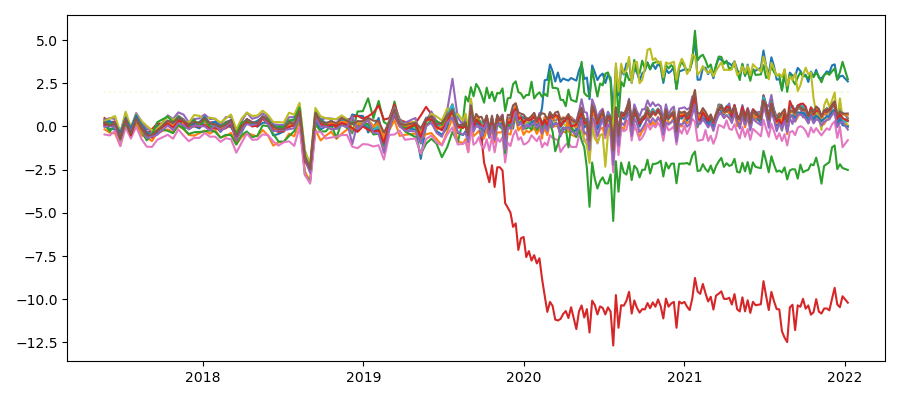

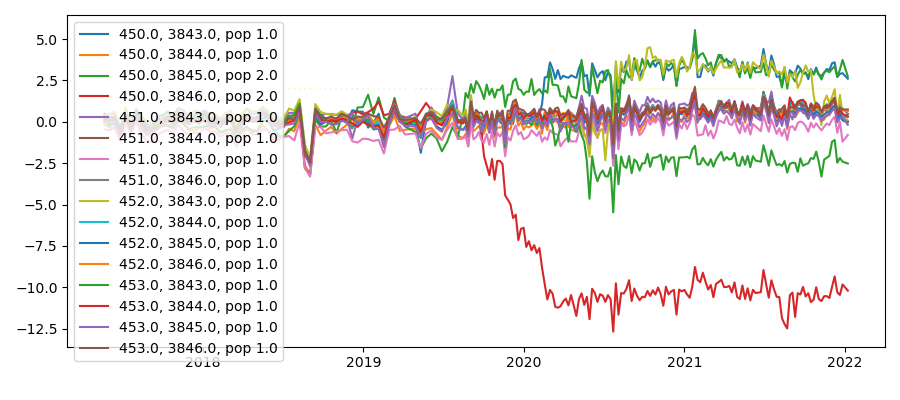

In [26]:
plt.figure(figsize=(9,4),tight_layout=True)
plt.scatter(t_datetime_pt1[1::],np.ones((nd-1))*2,c=coh_at_pixel_pt1,cmap='viridis',vmin=0,vmax=1,s=0.01)
for i in range(wid*wid):
    temp_label = str(Y_vals[i])+', '+str(X_vals[i])+', pop '+str(pop_vals[i])
    plt.plot(t_datetime_temp[1::],TS_all[i],'-',label=temp_label)
#plt.legend(bbox_to_anchor=(1.1, 1.05))
# y = 5
# for i in range(nd-1):
#     plt.hlines(y,t_datetime_temp[i],t_datetime_temp[i+1],color=coh_cmap(coh_avg[i]),linewidth=20)
# plt.colorbar(label='coherence',pad=0.02)
plt.show()

plt.figure(figsize=(9,4),tight_layout=True)
plt.scatter(t_datetime_pt1[1::],np.ones((nd-1))*2,c=coh_at_pixel_pt1,cmap='viridis',vmin=0,vmax=1,s=0.01)
for i in range(wid*wid):
    temp_label = str(Y_vals[i])+', '+str(X_vals[i])+', pop '+str(pop_vals[i])
    plt.plot(t_datetime_temp[1::],TS_all[i],'-',label=temp_label)
plt.legend()
# y = 5
# for i in range(nd-1):
#     plt.hlines(y,t_datetime_temp[i],t_datetime_temp[i+1],color=coh_cmap(coh_avg[i]),linewidth=20)
# plt.colorbar(label='coherence',pad=0.02)
plt.show()